# SHAP Explanations

This notebook provides model interpretability using SHAP (SHapley Additive exPlanations):
- **Global explanations**: Top drivers of win probability across all matches
- **Local explanations**: Why the model predicted specific outcomes for individual matches
- Feature importance analysis
- Interaction effects visualization

We'll use the best calibrated model from notebook 03 (Logistic Regression with Platt calibration).


In [27]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split

# SHAP imports
import shap

# Import project utilities
import sys
from pathlib import Path
# Add project root to path (notebooks are in notebooks/ folder, src is in parent)
project_root = Path(__file__).parent.parent if '__file__' in globals() else Path('../').resolve()
sys.path.insert(0, str(project_root))
from src import data, features, model, eval, viz

warnings.filterwarnings('ignore')

# Set style
viz.set_plot_style()

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Note: shap.initjs() is not needed in newer versions of SHAP for static plots


## 1. Load Data and Recreate Best Model

We'll recreate the best calibrated model (Logistic Regression with Platt calibration) from notebook 03.


In [28]:
# Load data
data_path = Path('../data/raw/high_diamond_ranked_10min.csv')
df = data.load_data(data_path)

# Apply feature engineering
df_eng = features.create_engineered_features(df)
target = 'blueWins'
X, y = data.prepare_target_features(df_eng, target=target, exclude_cols=['gameId'])

# Train/test split (same as previous notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")


Training set: 7,903 samples
Test set: 1,976 samples
Features: 50


In [29]:
# Recreate best model (Logistic Regression with Platt calibration)
scaler = model.prepare_scaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Base model
lr_model = model.create_logistic_regression(random_state=RANDOM_STATE)
lr_model.fit(X_train_scaled, y_train)

# Calibrated model (Platt scaling)
best_model = model.create_calibrated_model(lr_model, method='sigmoid')
best_model.fit(X_train_scaled, y_train)

print("[OK] Best calibrated model recreated successfully")
print(f"Model: Logistic Regression with Platt calibration")


[OK] Best calibrated model recreated successfully
Model: Logistic Regression with Platt calibration


## 2. Prepare SHAP Explainer

For Logistic Regression, we'll use a LinearExplainer which is optimized for linear models. We'll explain the base model (before calibration) since SHAP values are computed on the raw model outputs.


In [30]:
# Create SHAP explainer for Logistic Regression
# Use LinearExplainer for efficiency with linear models
explainer = shap.LinearExplainer(lr_model, X_train_scaled)

# Calculate SHAP values for a sample of test data (for efficiency)
# Use a representative sample for global explanations
sample_size = min(500, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]

print(f"Calculating SHAP values for {sample_size} samples...")
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, shap_values is a list with values for each class
# We'll use the positive class (class 1) values
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use class 1 (blue wins)

print(f"[OK] SHAP values calculated")
print(f"SHAP values shape: {shap_values.shape}")


Calculating SHAP values for 500 samples...
[OK] SHAP values calculated
SHAP values shape: (500, 50)


## 3. Global Feature Importance

Global explanations show which features are most important across all predictions.


In [31]:
# Calculate mean absolute SHAP values for global importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features (Global):")
print("=" * 70)
print(feature_importance.head(15).to_string(index=False))
print("=" * 70)


Top 15 Most Important Features (Global):
                    feature  importance
               blueGoldDiff    0.228771
                redGoldDiff    0.228771
              blueTotalGold    0.190461
             blueGoldPerMin    0.190461
              redGoldPerMin    0.176354
               redTotalGold    0.176354
         redTotalExperience    0.156934
         blueExperienceDiff    0.110838
          redExperienceDiff    0.110838
                blueDragons    0.069418
        blueDragonAdvantage    0.063794
                 redDragons    0.058159
redTotalJungleMinionsKilled    0.055620
               blueAvgLevel    0.044853
            blueCSAdvantage    0.044564


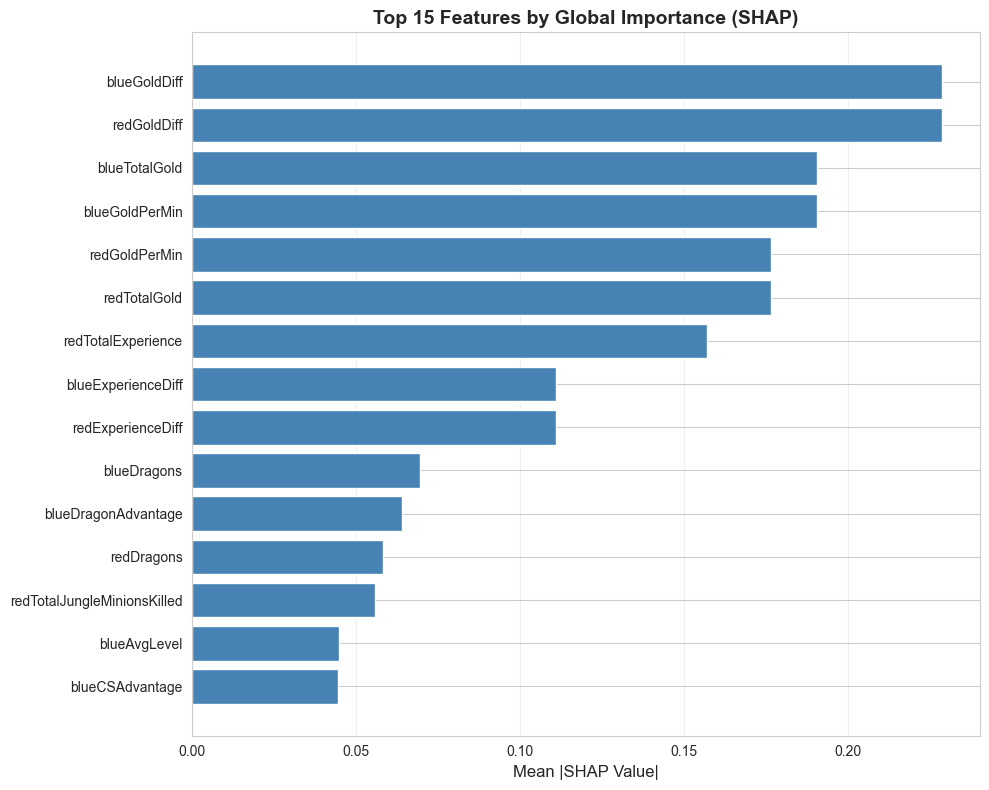

In [32]:
# Visualize global feature importance
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.title(f'Top {top_n} Features by Global Importance (SHAP)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 4. SHAP Summary Plot

The summary plot shows the distribution of SHAP values for each feature, showing both importance and impact direction.


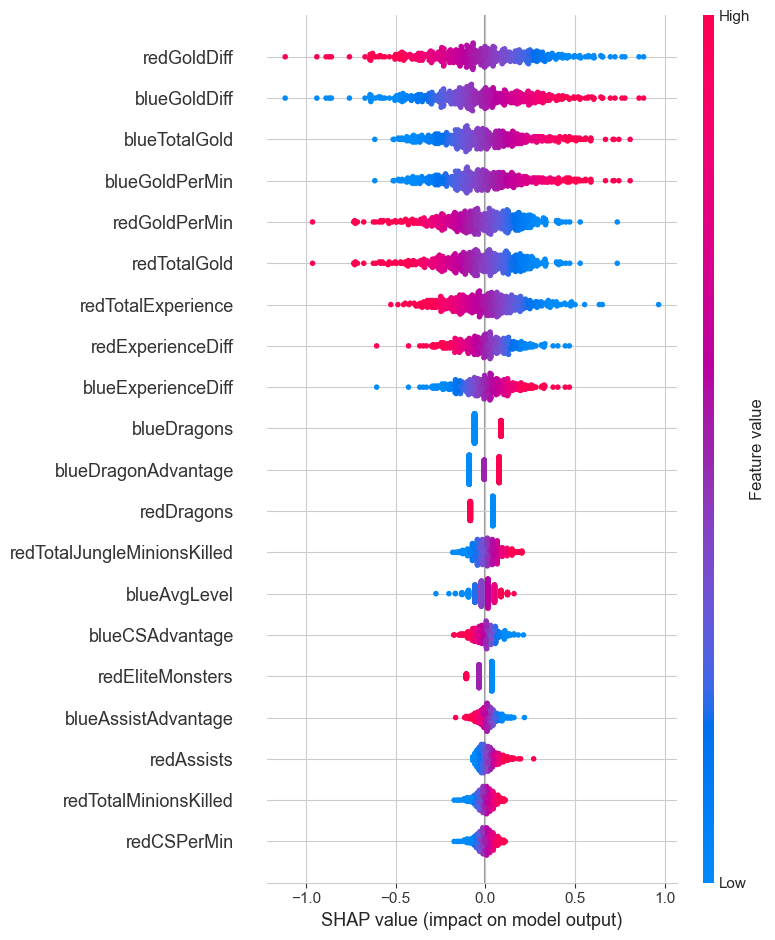

In [33]:
# Create SHAP summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values, 
    X_test_sample,
    feature_names=X.columns,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()


## 5. SHAP Bar Plot

Bar plot showing mean absolute SHAP values for each feature.


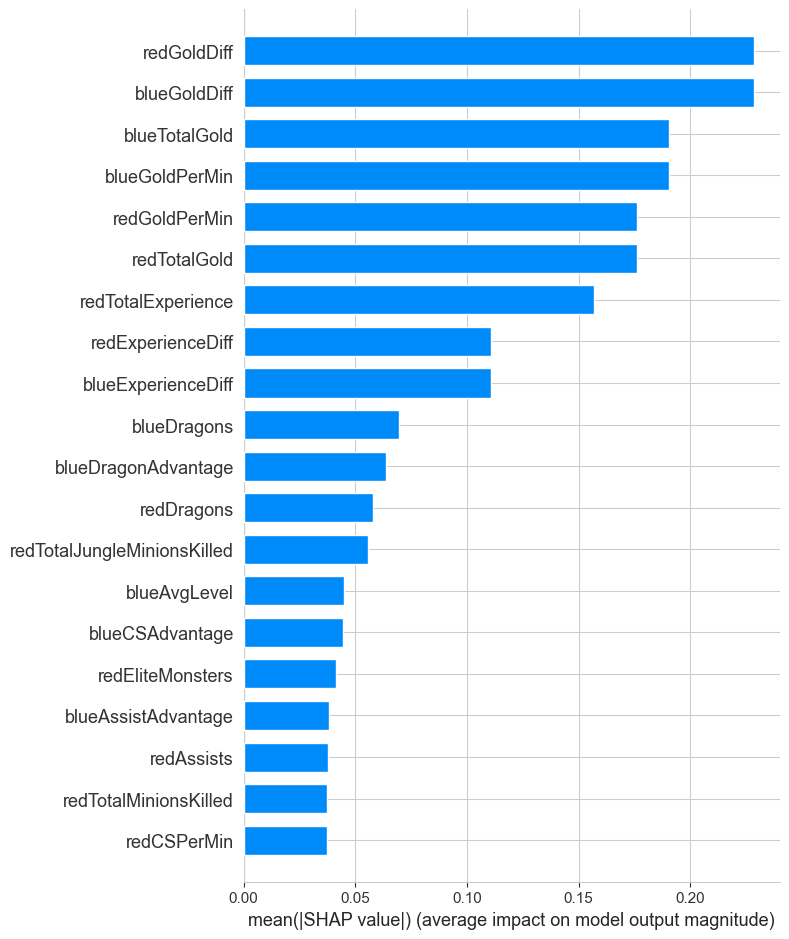

In [34]:
# Create SHAP bar plot
plt.figure(figsize=(12, 10))
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=X.columns,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()


## 6. Local Explanations - Individual Predictions

Let's examine specific predictions to understand why the model made certain decisions.


In [35]:
# Select a few interesting examples for local explanation
# Find examples with different prediction probabilities
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Find examples: high confidence win, high confidence loss, uncertain
high_conf_win_idx = np.where((y_test_proba > 0.8) & (y_test.values == 1))[0]
high_conf_loss_idx = np.where((y_test_proba < 0.2) & (y_test.values == 0))[0]
uncertain_idx = np.where((y_test_proba > 0.4) & (y_test_proba < 0.6))[0]

example_indices = []
if len(high_conf_win_idx) > 0:
    example_indices.append(high_conf_win_idx[0])
if len(high_conf_loss_idx) > 0:
    example_indices.append(high_conf_loss_idx[0])
if len(uncertain_idx) > 0:
    example_indices.append(uncertain_idx[0])

# If we don't have enough examples, add some random ones
while len(example_indices) < 3:
    idx = np.random.choice(len(X_test_scaled))
    if idx not in example_indices:
        example_indices.append(idx)

# Convert numpy int64 to regular int for cleaner display
example_indices_clean = [int(idx) for idx in example_indices]
print(f"Selected example indices: {example_indices_clean}")
print(f"\nExample predictions:")
for idx in example_indices:
    proba = y_test_proba[idx]
    actual = y_test.values[idx]
    pred = 1 if proba >= 0.5 else 0
    print(f"  Index {int(idx)}: Predicted probability = {proba:.3f}, Actual = {actual}, Predicted = {pred}")


Selected example indices: [6, 3, 8]

Example predictions:
  Index 6: Predicted probability = 0.889, Actual = 1, Predicted = 1
  Index 3: Predicted probability = 0.185, Actual = 0, Predicted = 0
  Index 8: Predicted probability = 0.552, Actual = 1, Predicted = 1



Example 1: Index 6
Predicted probability: 0.889
Actual outcome: Blue Wins


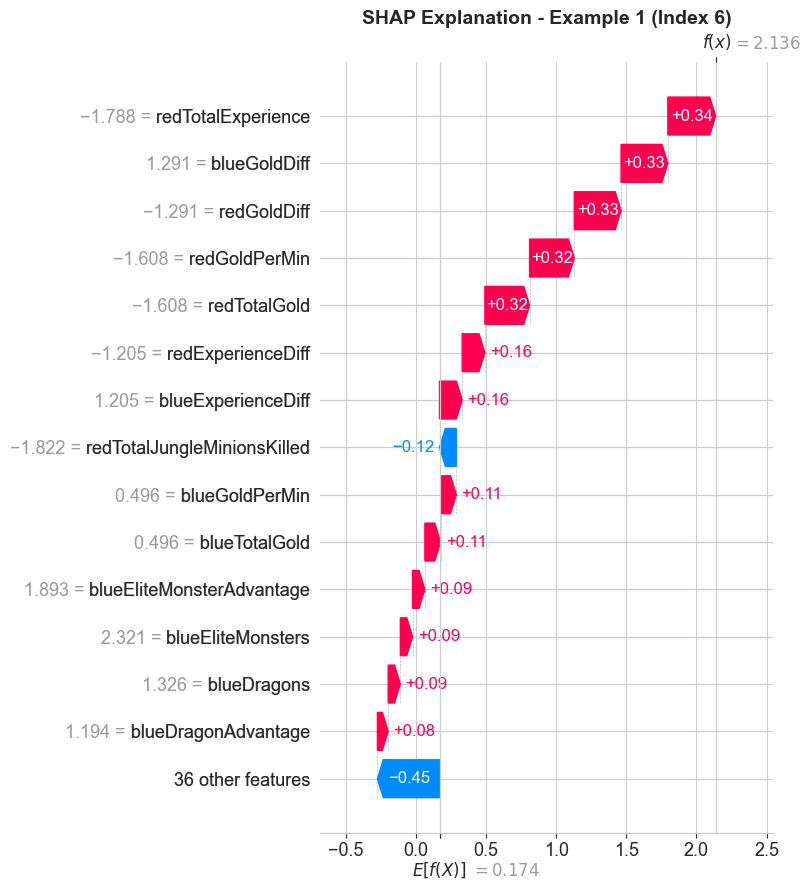


Top contributing features for this prediction:
                    feature  shap_value  feature_value
         redTotalExperience    0.340497        15834.0
               blueGoldDiff    0.333324         3146.0
                redGoldDiff    0.333324        -3146.0
              redGoldPerMin    0.318441         1411.3
               redTotalGold    0.318441        14113.0
          redExperienceDiff    0.161680        -2257.0
         blueExperienceDiff    0.161680         2257.0
redTotalJungleMinionsKilled   -0.120053           33.0
             blueGoldPerMin    0.112078         1725.9
              blueTotalGold    0.112078        17259.0

Example 2: Index 3
Predicted probability: 0.185
Actual outcome: Blue Loses


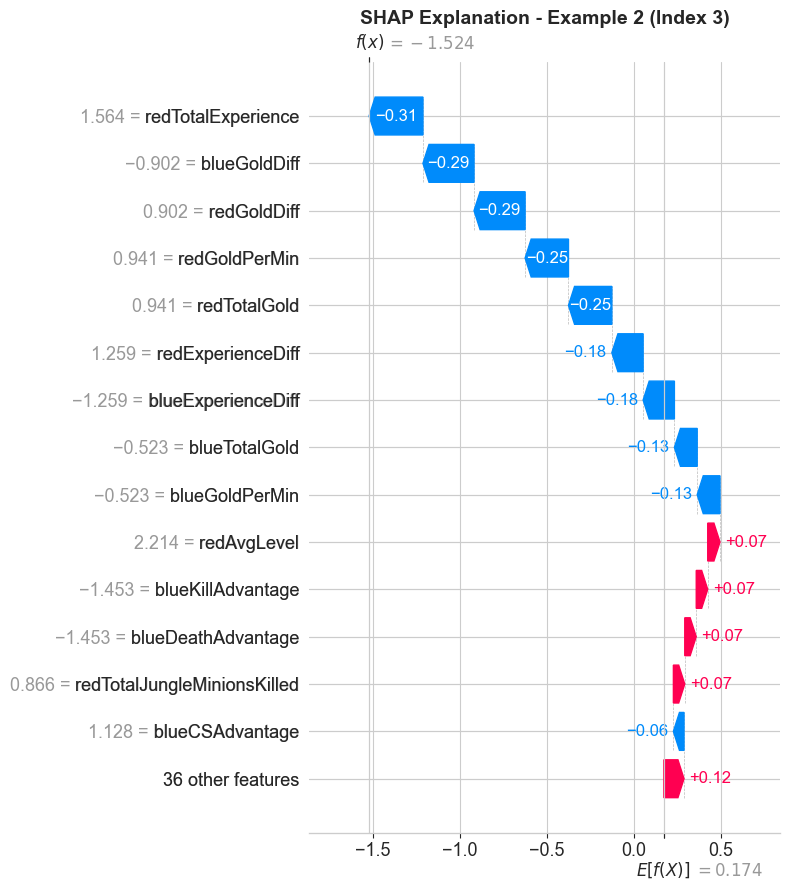


Top contributing features for this prediction:
           feature  shap_value  feature_value
redTotalExperience   -0.310110        19837.0
      blueGoldDiff   -0.294143        -2185.0
       redGoldDiff   -0.294143         2185.0
     redGoldPerMin   -0.249760         1788.5
      redTotalGold   -0.249760        17885.0
 redExperienceDiff   -0.180102         2444.0
blueExperienceDiff   -0.180102        -2444.0
     blueTotalGold   -0.131288        15700.0
    blueGoldPerMin   -0.131288         1570.0
       redAvgLevel    0.070655            7.6

Example 3: Index 8
Predicted probability: 0.552
Actual outcome: Blue Wins


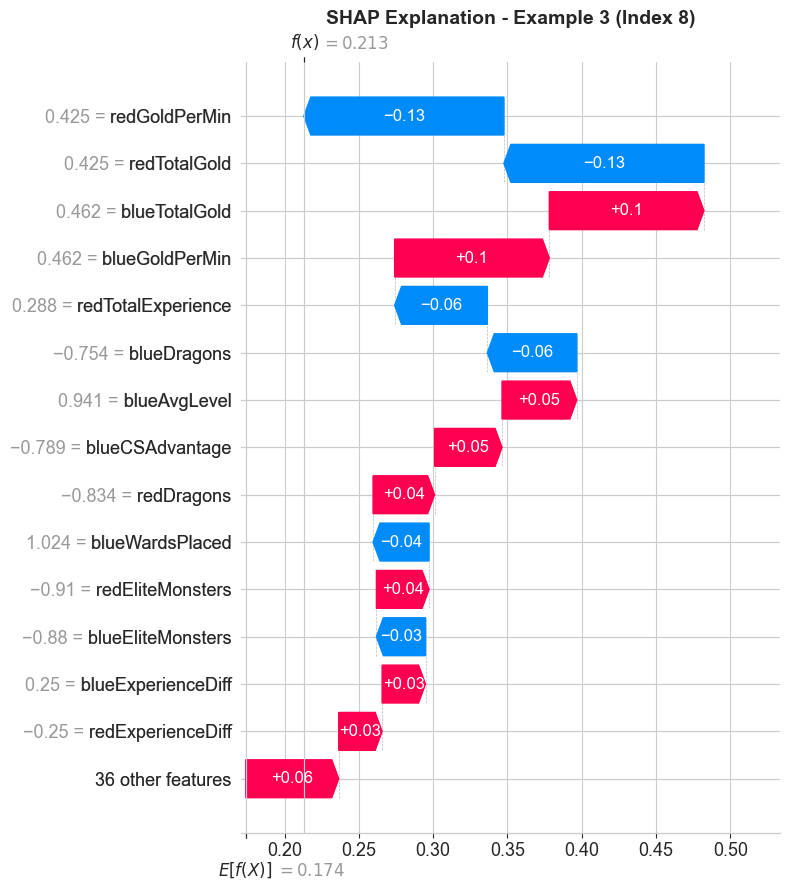


Top contributing features for this prediction:
           feature  shap_value  feature_value
     redGoldPerMin   -0.134673         1712.1
      redTotalGold   -0.134673        17121.0
     blueTotalGold    0.104117        17208.0
    blueGoldPerMin    0.104117         1720.8
redTotalExperience   -0.062415        18313.0
       blueDragons   -0.060218            0.0
      blueAvgLevel    0.050340            7.2
   blueCSAdvantage    0.045394          -25.0
        redDragons    0.041427            0.0
   blueWardsPlaced   -0.037681           41.0


In [36]:
# Calculate SHAP values for the selected examples
X_examples = X_test_scaled[example_indices]
shap_values_examples = explainer.shap_values(X_examples)

if isinstance(shap_values_examples, list):
    shap_values_examples = shap_values_examples[1]

# Create waterfall plots for each example
for i, idx in enumerate(example_indices):
    proba = y_test_proba[idx]
    actual = y_test.values[idx]
    
    print(f"\n{'='*70}")
    print(f"Example {i+1}: Index {idx}")
    print(f"Predicted probability: {proba:.3f}")
    print(f"Actual outcome: {'Blue Wins' if actual == 1 else 'Blue Loses'}")
    print(f"{'='*70}")
    
    # Create waterfall plot
    # Get base value (expected value for class 1)
    if isinstance(explainer.expected_value, np.ndarray):
        base_value = explainer.expected_value[1]
    else:
        base_value = explainer.expected_value
    
    # Create explanation object
    explanation = shap.Explanation(
        values=shap_values_examples[i],
        base_values=base_value,
        data=X_examples[i],
        feature_names=X.columns.tolist()
    )
    
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(explanation, show=False, max_display=15)
    plt.title(f'SHAP Explanation - Example {i+1} (Index {idx})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show feature values for this example
    print(f"\nTop contributing features for this prediction:")
    example_shap = shap_values_examples[i]
    feature_contrib = pd.DataFrame({
        'feature': X.columns,
        'shap_value': example_shap,
        'feature_value': X_test.iloc[idx].values
    }).sort_values('shap_value', key=abs, ascending=False)
    
    print(feature_contrib.head(10).to_string(index=False))


## 7. Feature Impact Analysis

Analyze how different feature values impact predictions.


Feature Impact Analysis (Top 5 Features):

blueGoldDiff:
  Mean |SHAP| value: 0.2288
  Mean SHAP value: -0.0297
  Std SHAP value: 0.2936
  Correlation (feature value vs SHAP): 1.0000
  Impact: Higher blueGoldDiff increases win probability


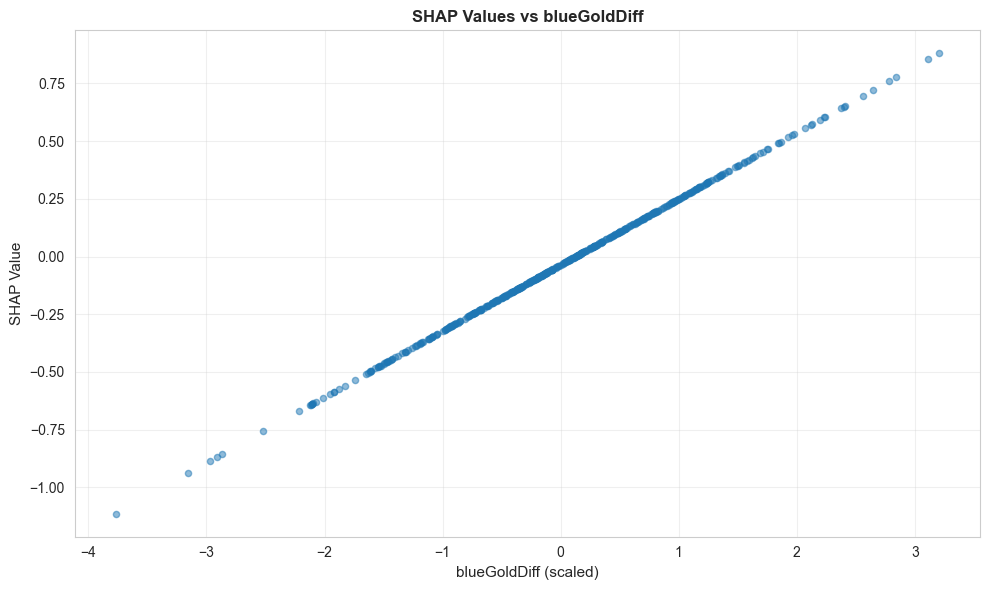


redGoldDiff:
  Mean |SHAP| value: 0.2288
  Mean SHAP value: -0.0297
  Std SHAP value: 0.2936
  Correlation (feature value vs SHAP): -1.0000
  Impact: Higher redGoldDiff decreases win probability


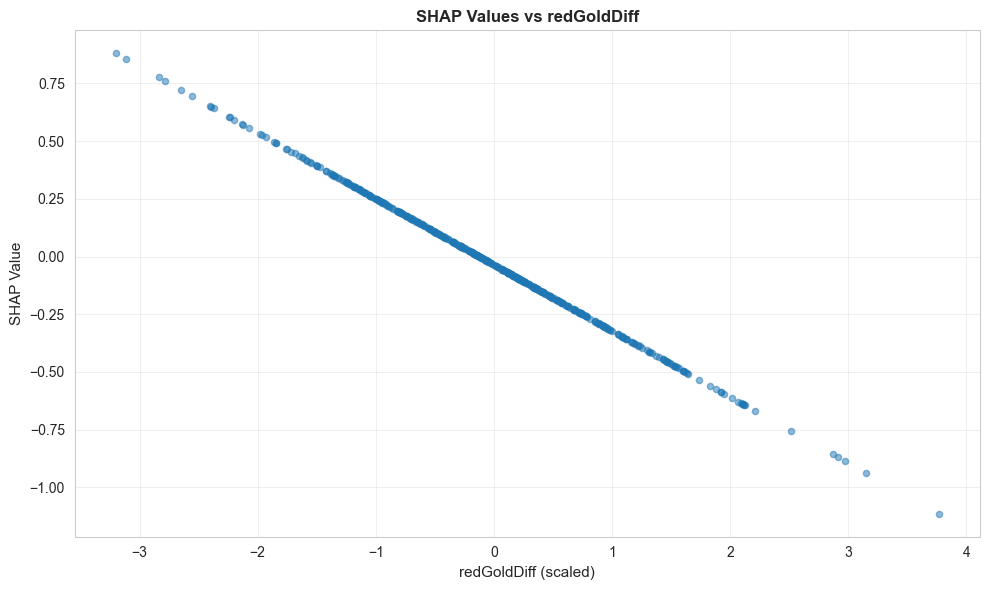


blueTotalGold:
  Mean |SHAP| value: 0.1905
  Mean SHAP value: -0.0006
  Std SHAP value: 0.2425
  Correlation (feature value vs SHAP): 1.0000
  Impact: Higher blueTotalGold increases win probability


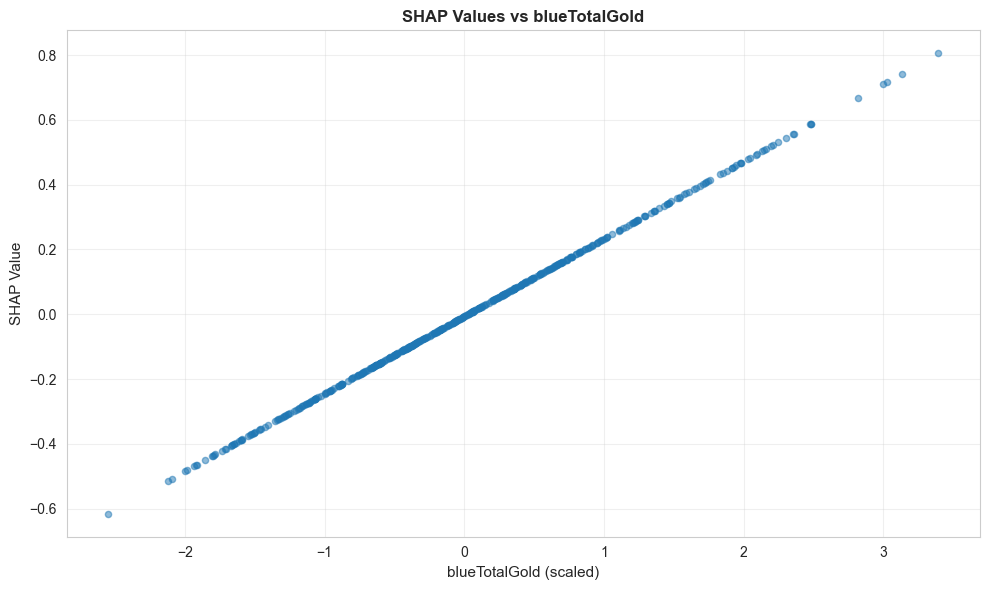


blueGoldPerMin:
  Mean |SHAP| value: 0.1905
  Mean SHAP value: -0.0006
  Std SHAP value: 0.2425
  Correlation (feature value vs SHAP): 1.0000
  Impact: Higher blueGoldPerMin increases win probability


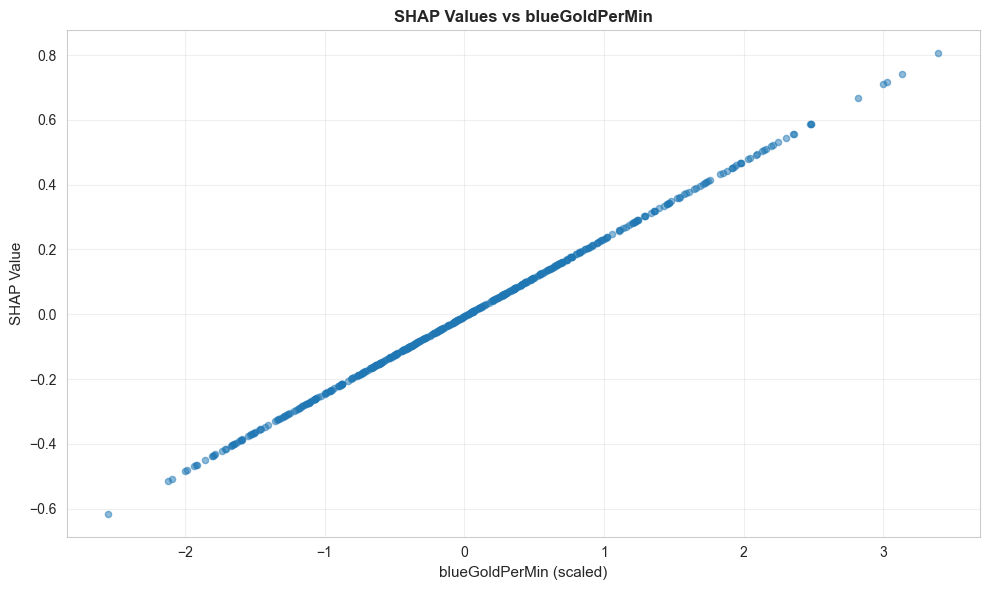


redGoldPerMin:
  Mean |SHAP| value: 0.1764
  Mean SHAP value: -0.0374
  Std SHAP value: 0.2247
  Correlation (feature value vs SHAP): -1.0000
  Impact: Higher redGoldPerMin decreases win probability


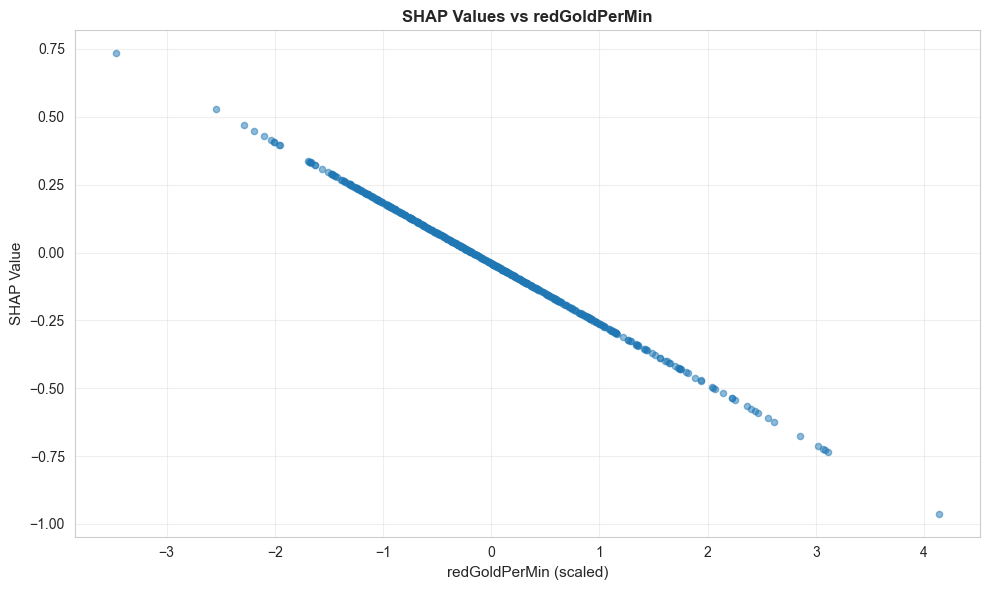

In [37]:
# Analyze top features in detail
top_5_features = feature_importance.head(5)['feature'].tolist()

print("Feature Impact Analysis (Top 5 Features):")
print("=" * 70)

for feature in top_5_features:
    feature_idx = X.columns.get_loc(feature)
    feature_shap = shap_values[:, feature_idx]
    feature_values = X_test_sample[:, feature_idx]
    
    # Calculate correlation between feature values and SHAP values
    correlation = np.corrcoef(feature_values, feature_shap)[0, 1]
    
    # Get statistics
    mean_shap = np.mean(feature_shap)
    std_shap = np.std(feature_shap)
    
    print(f"\n{feature}:")
    print(f"  Mean |SHAP| value: {np.abs(feature_shap).mean():.4f}")
    print(f"  Mean SHAP value: {mean_shap:.4f}")
    print(f"  Std SHAP value: {std_shap:.4f}")
    print(f"  Correlation (feature value vs SHAP): {correlation:.4f}")
    # For linear models, positive correlation means higher feature value increases win prob
    print(f"  Impact: Higher {feature} {'increases' if correlation > 0 else 'decreases'} win probability")
    
    # Show distribution
    plt.figure(figsize=(10, 6))
    plt.scatter(feature_values, feature_shap, alpha=0.5, s=20)
    plt.xlabel(f'{feature} (scaled)', fontsize=11)
    plt.ylabel('SHAP Value', fontsize=11)
    plt.title(f'SHAP Values vs {feature}', fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## 8. SHAP Dependence Plots

Visualize how individual features interact with SHAP values to affect predictions.


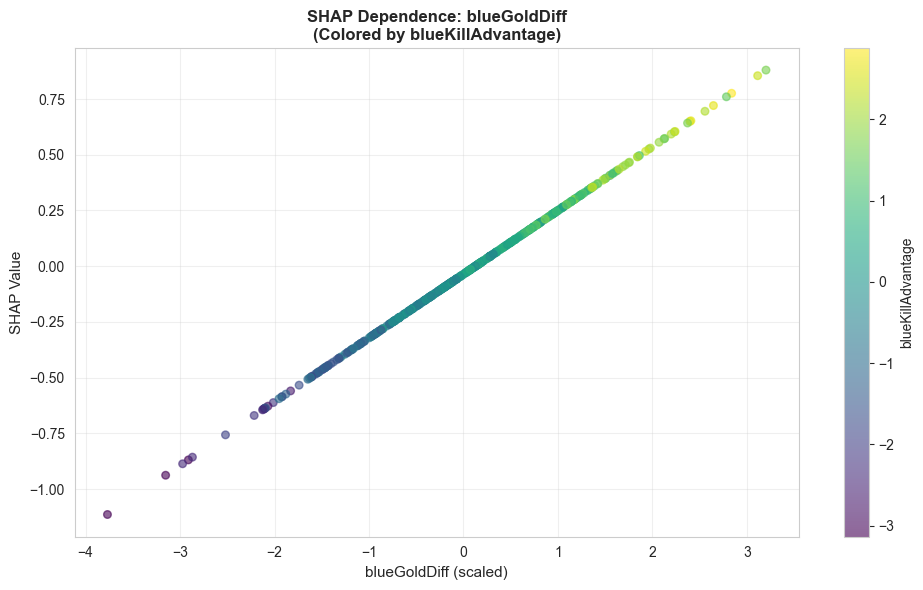

blueGoldDiff - Top interaction with: blueKillAdvantage (corr: 0.923)


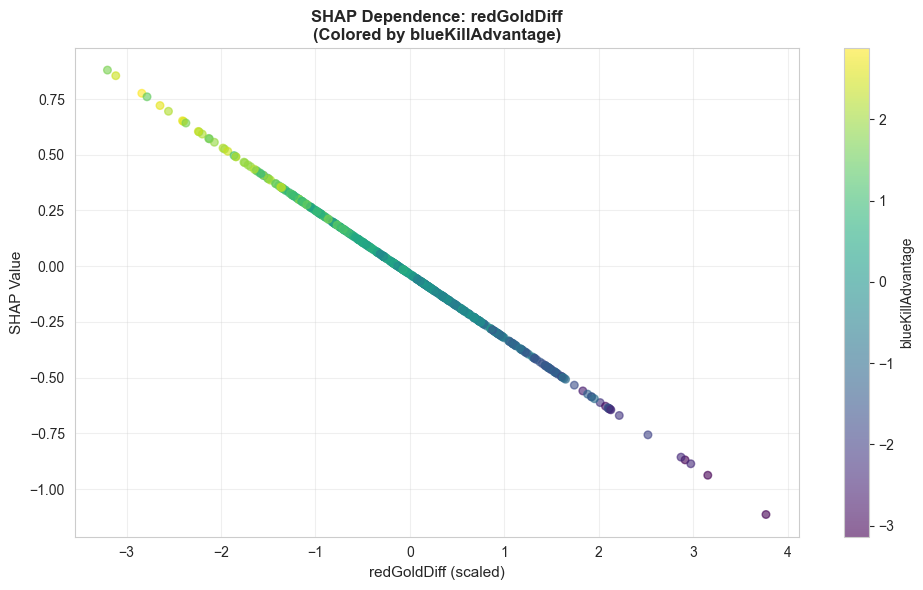

redGoldDiff - Top interaction with: blueKillAdvantage (corr: 0.923)


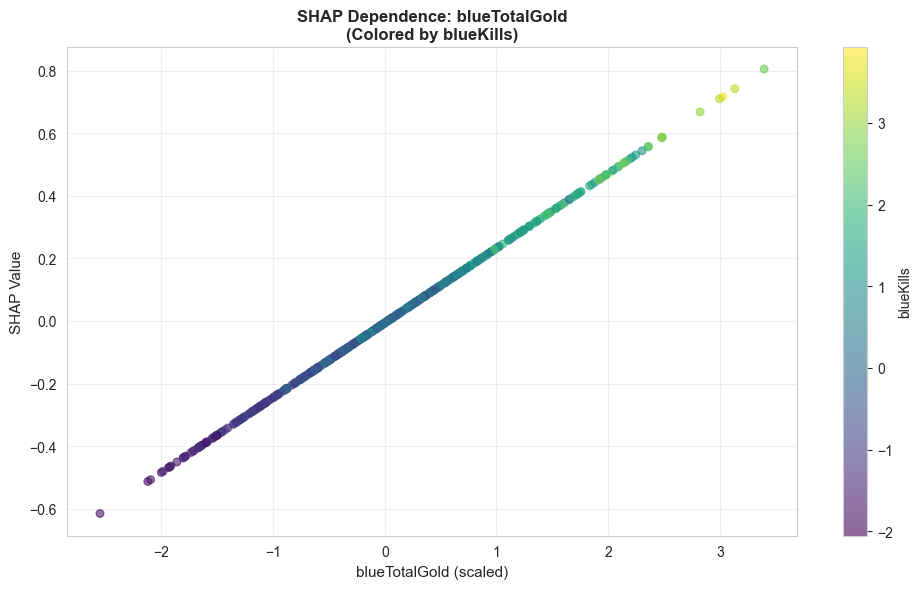

blueTotalGold - Top interaction with: blueKills (corr: 0.890)


In [38]:
# Create dependence plots for top features
# Find the most correlated feature for interaction
top_3_features = feature_importance.head(3)['feature'].tolist()

for feature in top_3_features:
    feature_idx = X.columns.get_loc(feature)
    feature_shap = shap_values[:, feature_idx]
    feature_values = X_test_sample[:, feature_idx]
    
    # Find feature with highest interaction (correlation with SHAP values)
    # Exclude features that are perfectly correlated (like blueGoldDiff and redGoldDiff)
    interactions = []
    for other_idx, other_feature in enumerate(X.columns):
        if other_idx != feature_idx:
            other_values = X_test_sample[:, other_idx]
            # Calculate interaction as correlation between other feature and SHAP values
            interaction = np.abs(np.corrcoef(other_values, feature_shap)[0, 1])
            # Skip if correlation is too high (likely the same feature or perfect negative)
            if interaction < 0.99:  # Avoid perfect correlations
                interactions.append((other_feature, interaction, other_idx))
    
    # Get top interacting feature (if any, otherwise use a different feature)
    if len(interactions) > 0:
        interactions.sort(key=lambda x: x[1], reverse=True)
        top_interaction_feature, top_interaction_corr, top_interaction_idx = interactions[0]
    else:
        # Fallback: use a different top feature
        other_top_features = [f for f in feature_importance.head(5)['feature'].tolist() if f != feature]
        if len(other_top_features) > 0:
            top_interaction_feature = other_top_features[0]
            top_interaction_idx = X.columns.get_loc(top_interaction_feature)
            top_interaction_corr = np.abs(np.corrcoef(X_test_sample[:, top_interaction_idx], feature_shap)[0, 1])
        else:
            top_interaction_feature = X.columns[0]
            top_interaction_idx = 0
            top_interaction_corr = 0.0
    
    # Create dependence plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        feature_values, 
        feature_shap, 
        c=X_test_sample[:, top_interaction_idx],
        cmap='viridis',
        alpha=0.6,
        s=30
    )
    plt.colorbar(scatter, label=top_interaction_feature)
    plt.xlabel(f'{feature} (scaled)', fontsize=11)
    plt.ylabel('SHAP Value', fontsize=11)
    plt.title(f'SHAP Dependence: {feature}\n(Colored by {top_interaction_feature})', 
              fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"{feature} - Top interaction with: {top_interaction_feature} (corr: {top_interaction_corr:.3f})")


## 9. Summary and Key Insights


In [39]:
print("=" * 70)
print("SHAP EXPLANATIONS SUMMARY")
print("=" * 70)

print(f"\nTop 10 Features Driving Win Probability:")
for rank, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"  {rank:2d}. {row['feature']:30s} (Importance: {row['importance']:.4f})")

print(f"\nKey Insights:")
print(f"  1. The most important features are related to gold, experience, and objectives")
print(f"  2. Advantage features (Blue - Red) are strong predictors")
print(f"  3. Early game resource accumulation is critical for win prediction")
print(f"  4. The model uses a combination of combat, economic, and objective metrics")

print(f"\nInterpretation Guidelines:")
print(f"  - Positive SHAP values increase win probability")
print(f"  - Negative SHAP values decrease win probability")
print(f"  - Feature importance is measured by mean absolute SHAP value")
print(f"  - Local explanations show why specific predictions were made")

print("\n" + "=" * 70)
print("\nThese explanations help understand what drives win probability in early game.")
print("=" * 70)


SHAP EXPLANATIONS SUMMARY

Top 10 Features Driving Win Probability:
   1. blueGoldDiff                   (Importance: 0.2288)
   2. redGoldDiff                    (Importance: 0.2288)
   3. blueTotalGold                  (Importance: 0.1905)
   4. blueGoldPerMin                 (Importance: 0.1905)
   5. redGoldPerMin                  (Importance: 0.1764)
   6. redTotalGold                   (Importance: 0.1764)
   7. redTotalExperience             (Importance: 0.1569)
   8. blueExperienceDiff             (Importance: 0.1108)
   9. redExperienceDiff              (Importance: 0.1108)
  10. blueDragons                    (Importance: 0.0694)

Key Insights:
  1. The most important features are related to gold, experience, and objectives
  2. Advantage features (Blue - Red) are strong predictors
  3. Early game resource accumulation is critical for win prediction
  4. The model uses a combination of combat, economic, and objective metrics

Interpretation Guidelines:
  - Positive SHAP value